In [6]:
import numpy as np

from Misc import energy_cons_check, plot_state

# Example: Single Pendulum

$$ 
\begin{align*}
\mathbb{L} &= T - V \\
&= \frac{1}{2}ml^2\dot{\theta}^2 + mgl \cos{\theta}
\end{align*}$$

which can be used below to give the 2nd-order ode that governs the dynamics of the system.

$$ 
\begin{align*}
&\frac{d}{dt} \left(  \frac{\partial L}{\partial \dot{\theta}}  \right) -  \frac{\partial L}{\partial \theta} = 0 \\
\implies & ml^2 \ddot{\theta} + mgl \sin{\theta} = 0
\end{align*}$$

Ideally when simulating the control of this system we could actually use a physical copy and the system and sensors to get state information. In many circumstances this is not possible. Instead we simulate the system.

It is important to note that to do this we are required to work in discrete time-steps and hence approximate the system. The code below illustrates the resulting artifacts.  

**Euler's**:

$$ \dot{\theta}_{k+1} = \dot{\theta}_k + \ddot{\theta}_k \Delta t + \mathcal{O}(\Delta t^2)$$

$$ \theta_{k+1} = \theta_k + \dot{\theta}_k \Delta t + \mathcal{O}(\Delta t^2)$$



In [7]:
G = 9.81
LENGTH = 1
MASS = 1

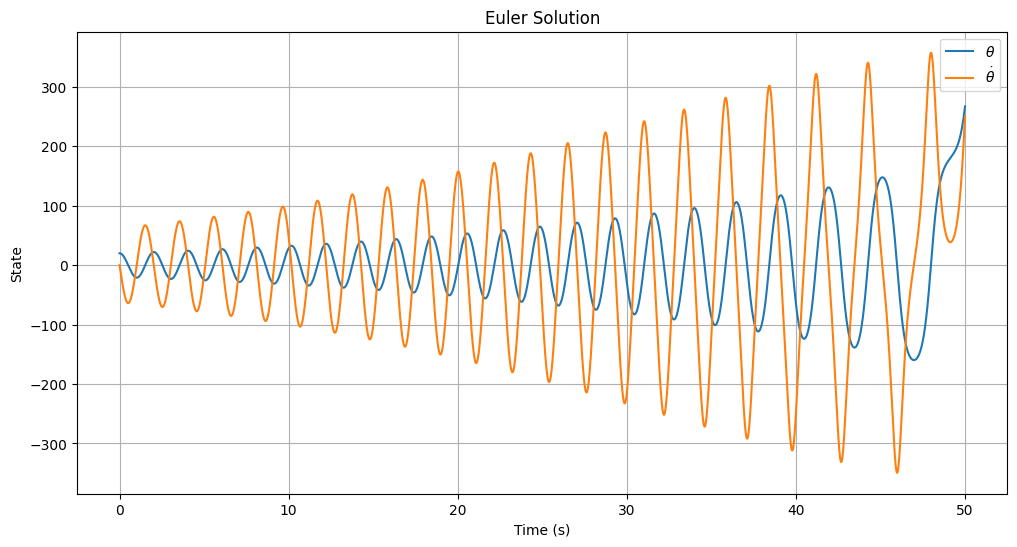

2.053478071847938


In [8]:
def euler_dynamics(x, u, length=1.0, g=9.81, dt=0.01):
    theta, theta_dot = x
    theta_ddot = -(g / length) * np.sin(theta) + u / (length**2)
    theta_dot_new = theta_dot + theta_ddot * dt
    theta_new = theta + theta_dot * dt
    return np.array([theta_new, theta_dot_new])


t_span = (0, 50)
dt = 0.01
t_eval = np.arange(t_span[0], t_span[1] + dt, dt)

# Simulate pendulum trajectory
control_input = np.zeros_like(0.5 * np.sin(t_eval))
theta_start = np.deg2rad(20)
x_start = np.array([theta_start, 0])  # Initial state: [theta, theta_dot]
trajectory = np.zeros((t_eval.shape[0], 2))
trajectory[0] = x_start

for i in range(1, t_eval.shape[0]):
    trajectory[i] = euler_dynamics(
        trajectory[i - 1], control_input[i - 1], length=LENGTH, g=G, dt=dt
    )

# Plot the pendulum trajectory
plot_state(
    t_eval, np.rad2deg(trajectory), "Euler Solution", [r"$\theta$", r"$\dot{\theta}$"]
)
energy_cons_check(trajectory, G, LENGTH, MASS)

Here we observe that the first order taylor expansion introduces a violation of the conservation of energy.

This can be proven by calculating the energy of the system at each time step.

We now move on to a method that has a bounded error on the energy.

**Sympletic Integrator**:

$$ \dot{\theta}_{k+1} = \dot{\theta}_k + \ddot{\theta}_k \Delta t + \mathcal{O}(\Delta t^2)$$

$$ \theta_{k+1} = \theta_k + \dot{\theta}_{k+1} \Delta t + \mathcal{O}(\Delta t^2)$$

If you're familiar with Hamiltonians, then this scheme conserves these properties of the system's slightly perturbed Hamiltonian:
- Volume in phase space (Liouville's theorem)
- Geometric structure of phase space

[This](https://en.wikipedia.org/wiki/Geometric_integrator) page has a nice example of what this means with a pendulum.

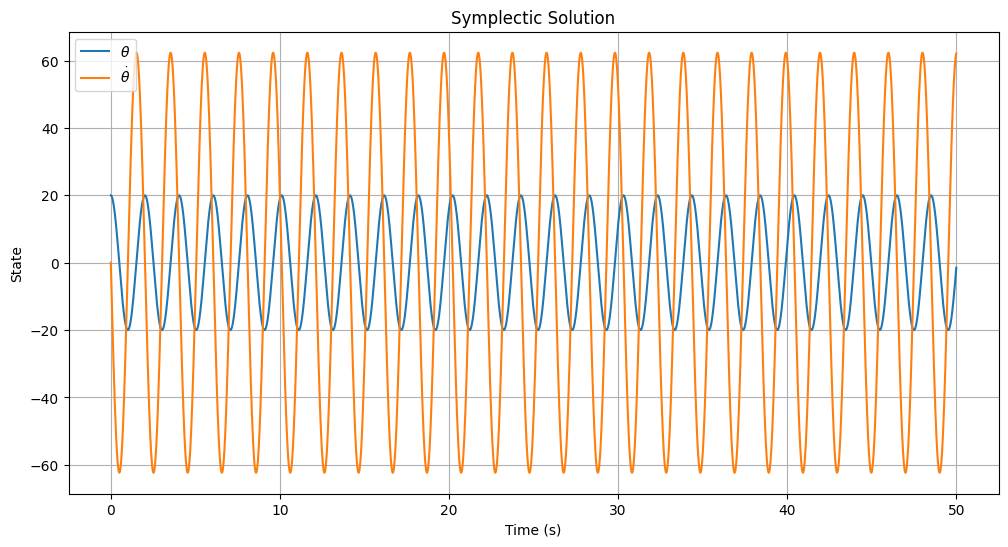

1.062186068036128


In [9]:
def symplectic_dynamics(x, u, length=1.0, g=9.81, dt=0.01):
    theta, theta_dot = x
    theta_ddot = -(g / length) * np.sin(theta) + u / (length**2)
    theta_dot_new = theta_dot + theta_ddot * dt
    theta_new = theta + theta_dot_new * dt
    return np.array([theta_new, theta_dot_new])


for i in range(1, t_eval.shape[0]):
    trajectory[i] = symplectic_dynamics(trajectory[i - 1], control_input[i - 1], dt=dt)

# Plot the pendulum trajectory
plot_state(
    t_eval,
    np.rad2deg(trajectory),
    "Symplectic Solution",
    [r"$\theta$", r"$\dot{\theta}$"],
)
energy_cons_check(trajectory, G, LENGTH, MASS)

As shown above the error is far more acceptable.

Whilst numerical ODEs arent the focus of these notebooks, this serves as a useful reminder to always understand the approximations you have made and the problems they could cause later on.

When predicting the dynamics of the system we constrain ourselves to the linear approximaiton of the dynamics as this allows optimisation using a QP. 

It is now clear why at each time step we only take the first optimal input out of the horizon of N.

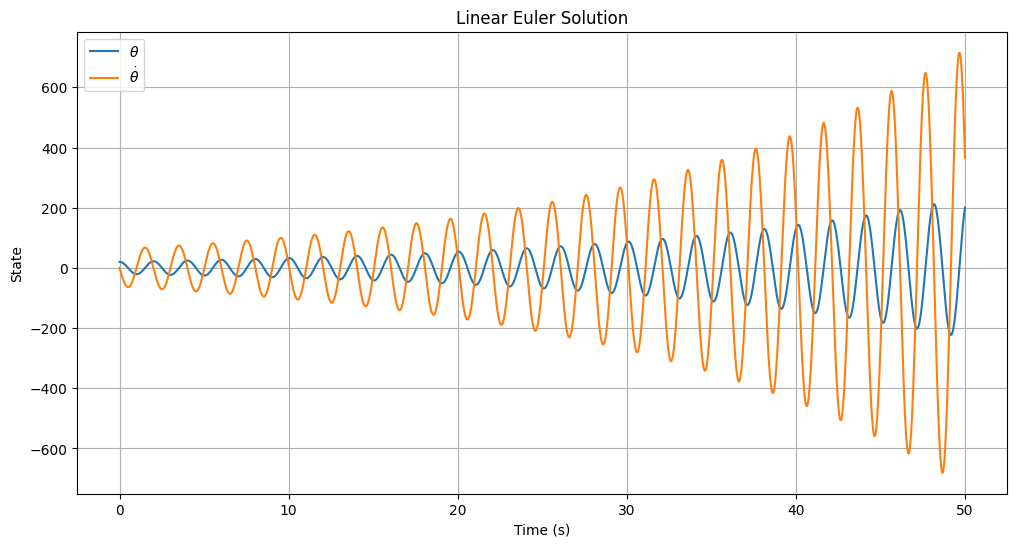

5.124244943178421


In [10]:
def linearised_euler_dynamics(length=1.0, g=9.81, dt=0.01):
    A_cont = np.array([[0, 1], [-g / length, 0]])
    B_cont = np.array([[0], [1 / (length**2)]])

    # Discretize using Euler method
    A_disc = np.eye(2) + A_cont * dt
    B_disc = B_cont * dt
    return A_disc, B_disc


# Simulate pendulum trajectory
A, B = linearised_euler_dynamics(length=1.0, g=9.81, dt=dt)

for i in range(1, t_eval.shape[0]):
    trajectory[i] = A @ trajectory[i - 1] + (B @ control_input[i, np.newaxis]).flatten()

# Plot the pendulum trajectory
plot_state(
    t_eval,
    np.rad2deg(trajectory),
    "Linear Euler Solution",
    [r"$\theta$", r"$\dot{\theta}$"],
)
energy_cons_check(trajectory, G, LENGTH, MASS)